In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import fredapi as fa
import requests
import json
import prettytable
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class MacroFactors:
    
    fred = fa.Fred("e9dded667e8d26a2ac0ea819620521dc")
    
    def __init__(self) -> None:
        self.dict_factors = {}
        self.dict_plots = {}
        #method calls
        x = self.FRED_data_loader()
        y = self.B_of_L_loader()
        self.inflation(self.dict_factors, 12)
        
        self.excel_writer(self.dict_factors)
    
    def get_FRED_data(self, str_factor):
        '''
        Code used to retrieve data from the FED.
        '''
        if type(str_factor) == str:
            series_factor = self.fred.get_series(str_factor)
            return series_factor
        else:
            raise TypeError("The input for the macroeconomic factor should be a string")

    def period_to_month(self, column):
    # Turns the month values into numbers that can be understood by pandas
        if column == "M01":
            column = 1
        if column == "M02":
            column = 2
        if column == "M03":
            column = 3
        if column == "M04":
            column = 4
        if column == "M05":
            column = 5
        if column == "M06":
            column = 6
        if column == "M07":
            column = 7
        if column == "M08":
            column = 8
        if column == "M09":
            column = 9
        if column == "M10":
            column = 10
        if column == "M11":
            column = 11
        if column == "M12":
            column = 12
        
        return column

    def get_BofL_data(self, str_factor, str_ID, str_start_year, str_end_year): 
        """
        Code used to access the Bureau of Labor Statistics API.
        Converts the data into a dataframe.
        """
        
        if isinstance(str_factor, str) and isinstance(str_ID, str) and isinstance(str_start_year, str) and isinstance(str_end_year, str):
            headers = {'Content-type': 'application/json'}
            data = json.dumps({"seriesid": [str_ID], "startyear": str_start_year, "endyear":str_end_year, "registrationkey": "38cbbfb1038446378c6e795256489334"})
            p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
            json_data = json.loads(p.text)
            
            for series in json_data['Results']['series']:
                x = prettytable.PrettyTable(["series id","year","period","value","footnotes"])
                seriesId = series['seriesID']
                for item in series['data']:
                    year = item['year']
                    period = item['period']
                    value = item['value']
                    footnotes=""
                    for footnote in item['footnotes']:
                        if footnote:
                            footnotes = footnotes + footnote['text'] + ','
                    if 'M01' <= period <= 'M12':
                        x.add_row([seriesId,year,period,value,footnotes[0:-1]])

            x_as_csv = x.get_csv_string().replace('\r','')
            text_file = open(f"{str_factor}.csv", "w")
            n = text_file.write(x_as_csv)
            text_file.close()
            df_x = pd.read_csv(f"{str_factor}.csv")
            df_factor = df_x.loc[::-1].reset_index(drop=True)
            df_factor["month"] = df_factor["period"].apply(self.period_to_month)
            df_factor = df_factor.assign(Date=pd.to_datetime(df_factor[['year', 'month']].assign(day=1)))
            
            return df_factor
            
        else:
            raise TypeError("All inputs must be strings")
        
    def plot_factor(self, series_factor, x_label, y_label):
        figure = plt.figure()
        plt.plot(series_factor.index, series_factor.values)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        return figure
    
    def FRED_data_loader(self):
        dict_FRED = {'CCI': 'UMCSENT', 'Jobless Claims': 'ICSA', 'Durable Goods Orders': 'DGORDER', 'GDP': 'GDP', 'Yield Curve': 'T10Y2Y', "Retail Sales": 'RSXFS', "PCE": "PCE", "Existing Home Sales": 'EXHOSLUSM495S'}
        
        for x in dict_FRED:
            code = dict_FRED[x]
            series_factor = (self.get_FRED_data(code)).dropna()
            self.dict_factors[x] = series_factor
            if x == "CCI":
                display(f"The most recent calculation of the {x} in the US is {series_factor[-1]}")
            if x == "Jobless Claims":
                display(f"The most recent calculation of the weekly number of {x} in the US is {series_factor[-1]}")
            if x == "Durable Goods Orders":
                display(f"The most recent calculation of the number of durable goods orders in the US is {series_factor[-1]}")
            if x == "GDP":
                display(f"The most recent calculation of the {x} in the US is ${series_factor[-1]*1000000000}")
            if x == "Yield Curve":
                display(f"The most recent calculation of the 10 Year - 2 Year T Bill Maturity is {(series_factor[-1])}")
            if x == "Retail Sales":
                display(f"The most recent calculation of the retail sales in the US is {(series_factor[-1])} people")
            if x == "PCE":
                display(f"The most recent calculation of the Personal Consumption Expenditures in the US is {(series_factor[-1])} people")
            if x == "Existing Home Sales":
                display(f"The most recent calculation of home sales in the US is {(series_factor[-1])} people")
            else:
                pass
            figure = self.plot_factor(series_factor, "Year", f"{x}")
            self.dict_plots[x]=figure
        return series_factor
    
    def B_of_L_loader(self):
        dict_B_of_L = {'CPI': 'CUUR0000SA0', 'Employment Number': 'LNS12000000', 'Unemployment Rate': 'LNS14000000'}
        
        for x in dict_B_of_L:
            df = (self.get_BofL_data(x, dict_B_of_L[x], '2004', '2024'))
            df = df[["value", "Date"]] 
            series = df.set_index("Date") 
            self.dict_factors[x] = series
            if x == "CPI":
                display(f"The most recent calculation of the {x} in the US is {float(series.iloc[-1])}")
            if x == "Employment Number":
                display(f"The most recent calculation of the {x} in the US is {float(series.iloc[-1])}")
            if x == "Unemployment Rate":
                display(f"The most recent calculation of the {x} in the US is {float(series.iloc[-1])}")
            figure = self.plot_factor(series, "Year", f"{x}")
            self.dict_plots[x] = figure
        return series
    
    def inflation(self, dict, time):
        series_CPI = dict["CPI"]
        inflation = float(((series_CPI.iloc[-1] - series_CPI.iloc[-(time+1)])) /series_CPI.iloc[-(time+1)] * 100)
        display(f"The inflation calculated from the CPI for the last {time} months is {round(inflation,3)} %")
        return inflation
    
    def excel_writer(self, dict_factors):
        writer = pd.ExcelWriter(r"C:\Users\mattp\Quant_Finance\SMIF\Data Base\Basic Macro Factors\Macroeconomic Factors.xlsx")
        
        for key in dict_factors:
            new_dataframe = dict_factors[key]
            new_dataframe.to_excel(writer, sheet_name=key)
        writer.close()
    
    

'The most recent calculation of the CCI in the US is 76.9'

'The most recent calculation of the weekly number of Jobless Claims in the US is 211000.0'

'The most recent calculation of the number of durable goods orders in the US is 277746.0'

'The most recent calculation of the GDP in the US is $27956998000000.0'

'The most recent calculation of the 10 Year - 2 Year T Bill Maturity is -0.34'

'The most recent calculation of the retail sales in the US is 615862.0 people'

'The most recent calculation of the Personal Consumption Expenditures in the US is 19189.0 people'

'The most recent calculation of home sales in the US is 4380000.0 people'

C:\Users\mattp\AppData\Local\Temp\ipykernel_24040\931332228.py:139: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  display(f"The most recent calculation of the {x} in the US is {float(series.iloc[-1])}")


'The most recent calculation of the CPI in the US is 306.746'

C:\Users\mattp\AppData\Local\Temp\ipykernel_24040\931332228.py:141: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  display(f"The most recent calculation of the {x} in the US is {float(series.iloc[-1])}")


'The most recent calculation of the Employment Number in the US is 161183.0'

C:\Users\mattp\AppData\Local\Temp\ipykernel_24040\931332228.py:143: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  display(f"The most recent calculation of the {x} in the US is {float(series.iloc[-1])}")


'The most recent calculation of the Unemployment Rate in the US is 3.7'

C:\Users\mattp\AppData\Local\Temp\ipykernel_24040\931332228.py:150: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  inflation = float(((series_CPI.iloc[-1] - series_CPI.iloc[-(time+1)])) /series_CPI.iloc[-(time+1)] * 100)


'The inflation calculated from the CPI for the last 12 months is 3.352 %'

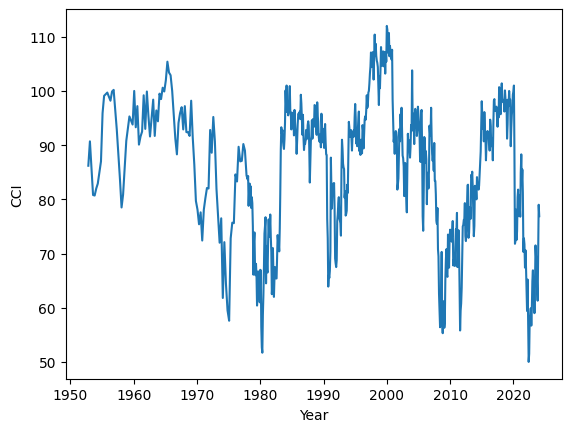

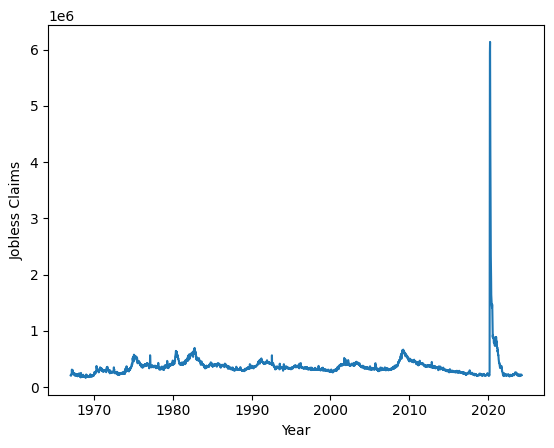

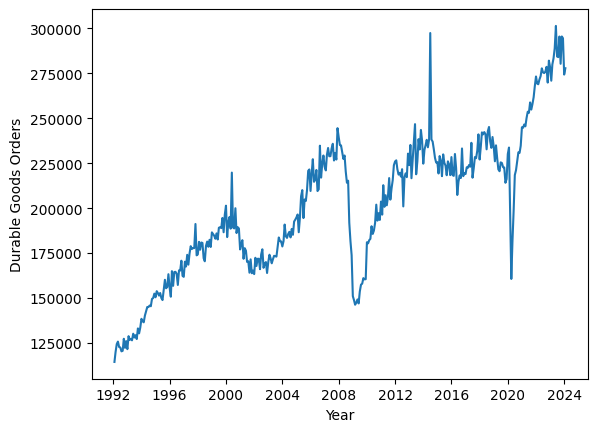

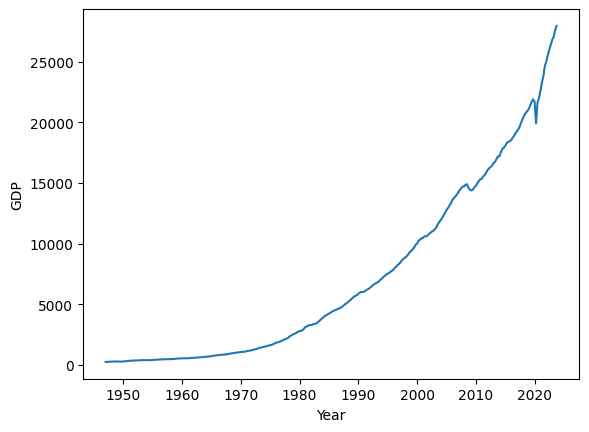

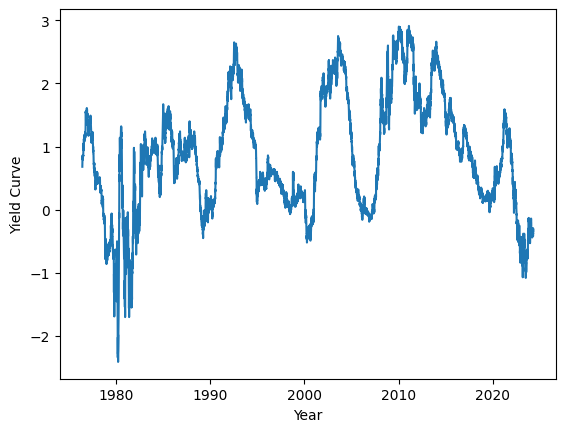

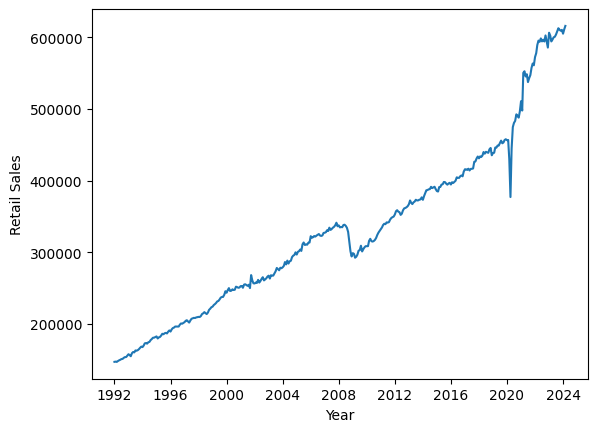

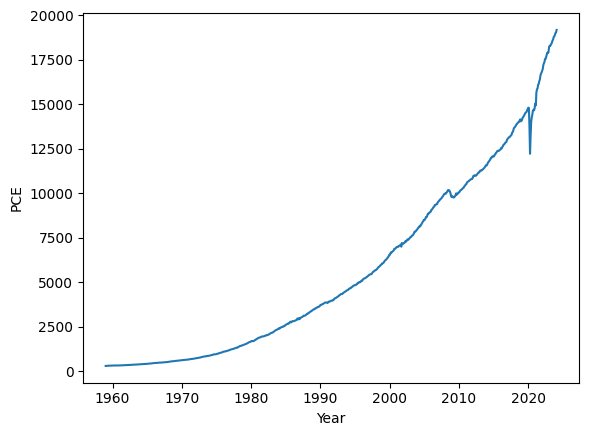

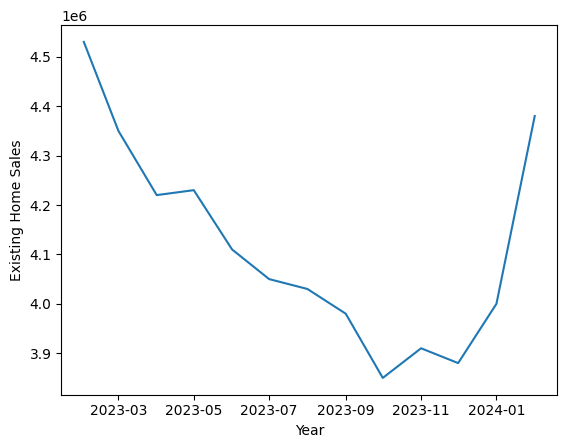

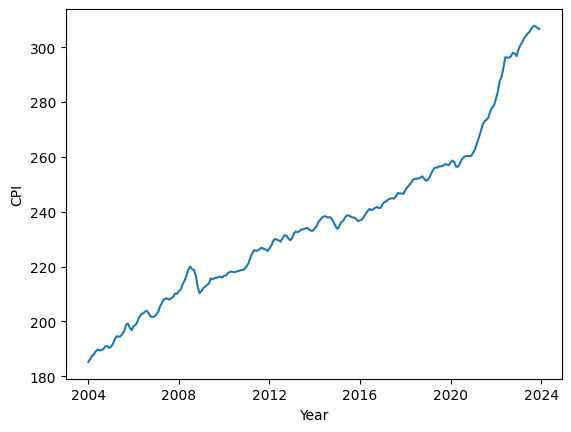

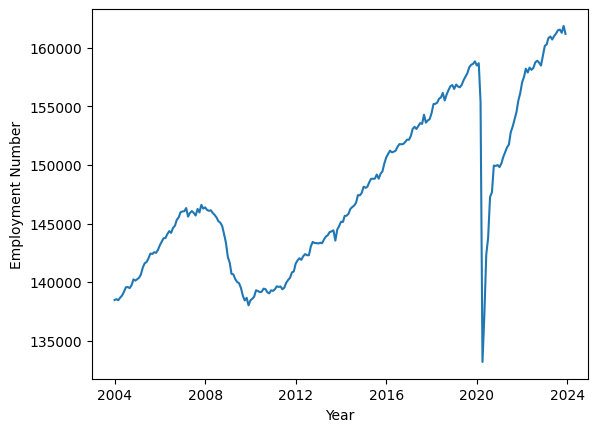

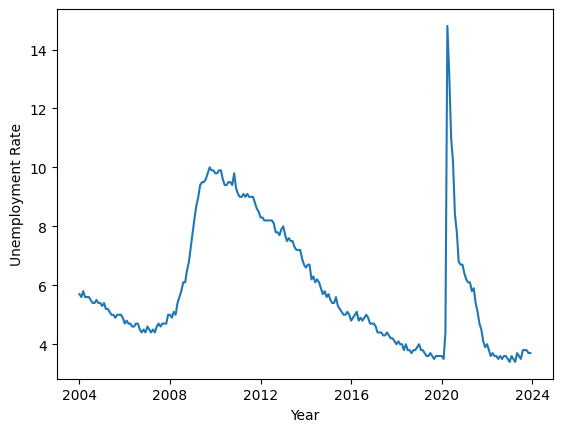

In [3]:
yo = MacroFactors()